# 실습 - 허리케인 피해 지역 구분하기


## 개요
  - 허리케인이 지나간 위치의 위성 이미지를 보고, 피해 여부를 판단하는 모델을 만들어 봅시다.

## 목표
  - validation dataset 에 대해 95% 이상의 정확도를 가지는 것이 목표입니다.

In [1]:
import urllib
import zipfile

import tensorflow as tf

In [ ]:
def download_and_extract_data():
    url = 'https://storage.googleapis.com/download.tensorflow.org/data/certificate/satellitehurricaneimages.zip'
    urllib.request.urlretrieve(url, 'satellitehurricaneimages.zip')
    with zipfile.ZipFile('satellitehurricaneimages.zip', 'r') as zip_ref:
        zip_ref.extractall()

download_and_extract_data()

# 1. 이미지 전처리

  - image 전처리를 담당하는 함수를 만들어 봅시다.
  - 간단한 normalize 만 수행해도 충분합니다. 

In [2]:
def preprocess(image, label):
    # 함수 내용을 작성하세요.
    image = image/255

    return image, label

# 2. 데이터 준비

  - 다운로드 받은 데이터를 읽어서 준비합니다.
  - 위에서 정의한 preprocess 함수를 이용하여 전처리를 수행합니다.

In [3]:
IMG_SIZE = 128
BATCH_SIZE = 64

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory='train/',
    image_size= (IMG_SIZE,IMG_SIZE)
    , batch_size=BATCH_SIZE)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory='validation/',
    image_size= (IMG_SIZE,IMG_SIZE)
    , batch_size=BATCH_SIZE)


train_ds = train_ds.map(
        preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE).prefetch(
        tf.data.experimental.AUTOTUNE)
val_ds = val_ds.map(
        preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

Found 10000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


# 3. 모델 정의

  - 모델 모양을 정의합니다.
  - Input, Output 모양을 유의하세요.

In [4]:
model = tf.keras.models.Sequential([
    # 함수 내용을 작성하세요.
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

# 4. 모델 컴파일

  - 학습 방법을 정의하세요
  - loss, optimizer, metrics 를 올바르게 지정하면 충분합니다.

In [5]:
model.compile(
    # 함수 내용을 작성하세요.
            loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']
)

# 5. 모델 학습

  - 학습을 위한 epoch, batch_size 등을 설정하세요.
  - 이 외에 사용하고 싶은 기법들은 자유롭게 도입하셔도 됩니다.

In [10]:
model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=10,
)

Epoch 1/10
157/157 [==============================] - 44s 276ms/step - loss: 0.0249 - accuracy: 0.9919 - val_loss: 0.1842 - val_accuracy: 0.9505
Epoch 2/10
157/157 [==============================] - 44s 277ms/step - loss: 0.0341 - accuracy: 0.9896 - val_loss: 0.1939 - val_accuracy: 0.9425
Epoch 3/10
157/157 [==============================] - 44s 278ms/step - loss: 0.0214 - accuracy: 0.9927 - val_loss: 0.1415 - val_accuracy: 0.9605
Epoch 4/10
157/157 [==============================] - 44s 278ms/step - loss: 0.0205 - accuracy: 0.9930 - val_loss: 0.1428 - val_accuracy: 0.9505
Epoch 5/10
157/157 [==============================] - 44s 278ms/step - loss: 0.0171 - accuracy: 0.9953 - val_loss: 0.1927 - val_accuracy: 0.9505
Epoch 6/10
157/157 [==============================] - 44s 276ms/step - loss: 0.0215 - accuracy: 0.9926 - val_loss: 0.2123 - val_accuracy: 0.9490
Epoch 7/10
157/157 [==============================] - 44s 281ms/step - loss: 0.0155 - accuracy: 0.9954 - val_loss: 0.2023 - val_ac

In [11]:
model.save("hurr_model.h5")

C:\Users\jhpark\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Appendix

- 이미지를 View 합니다.
- model 로 predict 를 합니다.

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Take one batch of images and labels
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory='validation/',
    image_size= (IMG_SIZE,IMG_SIZE)
    , batch_size=BATCH_SIZE)

Found 2000 files belonging to 2 classes.


1/1 [==============================] - 0s 33ms/step


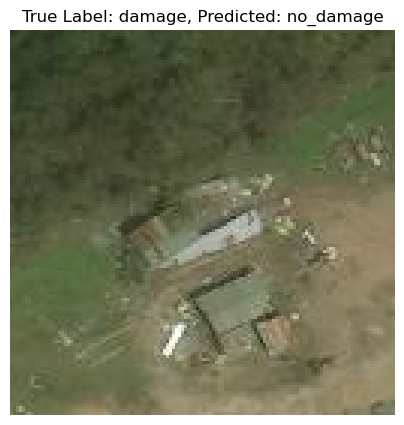

In [14]:
images, labels = next(iter(val_ds.shuffle(buffer_size=10000)))

data_index = 5

selected_image = images[data_index].numpy().astype("uint8")
selected_label = labels[data_index].numpy()

image_to_predict = np.expand_dims(selected_image/255, axis=0)

# Make a prediction
predictions = model.predict(image_to_predict)
predicted_label = int(predictions.round())

plt.figure(figsize=(5,5))
plt.imshow(selected_image)
class_names = val_ds.class_names
plt.title(f"True Label: {class_names[selected_label]}, Predicted: {class_names[predicted_label]}")
plt.axis("off")
plt.show()

# Transfer Learning

- transfer learning 을 이용해서도 풀어봅시다.

In [ ]:
# 자유롭게 작성하세요.